In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

results_dir = '../../results/mean_experiment'

sns.set_theme(style="white")

def draw_checkpoint_line(ax, df_model_results, palette, linestyles):
    for idx_exp, experiment in enumerate(df_model_results['Experiment'].unique()):
        df_experiment = df_model_results[df_model_results['Experiment'] == experiment]
        df_experiment = df_experiment.sort_values(by='Experiment')

        ax.axvline(x=df_experiment['Epoch'].iloc[0], color=palette[idx_exp], linestyle=linestyles[idx_exp], linewidth=1)


def plot_loss_curves(df_losses, palette=sns.color_palette("tab10")):
    models = df_losses['Model'].unique()
    if len(models) == 0:
        raise ValueError("No models found in the DataFrame.")
    
    fig, ax = plt.subplots(ncols=2,nrows=len(models), figsize=(12*len(models), 6*len(models)), sharex=True, sharey=False)

    for idx, m in enumerate(models):
        df_model = df_losses[df_losses['Model'] == m]
        df_model = df_model.sort_values(by='Experiment')

        ax_left = ax[idx, 0] if len(models) > 1 else ax[0]
        ax_right = ax[idx, 1] if len(models) > 1 else ax[1]

        sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax_left)
        sns.lineplot(data=df_model, x='Epoch', y='val_auroc', hue='Experiment', palette=palette, ax=ax_right)
        ax_left.set(title=f'Train Loss - {m}', ylabel='BCE Loss')
        ax_right.set(title=f'AUROC - {m}')
                
    plt.tight_layout()
    
    return fig

def plot_auroc_curves(df, df_results=None, palette=sns.color_palette("tab10"), linestyles = ['-.','--',':']):
    models = df['Model'].unique()
    if len(models) == 0:
        raise ValueError("No models found in the DataFrame.")
    
    fig, ax = plt.subplots(figsize=(6*len(models), 6*len(models)), sharex=True, sharey=True, ncols=len(models))

    for idx, m in enumerate(models):
        df_model = df[df['Model'] == m]

        fig_ax = ax[idx] if len(models) > 1 else ax

        sns.lineplot(data=df_model, x='Epoch', y='val_auroc', hue='Experiment', ax=fig_ax)
        fig_ax.set(title=f'AUROC - {m}', ylabel='AUROC')

        if df_results is not None:
            df_model_results = df_results[df_results['Model'] == m]
            draw_checkpoint_line(fig_ax, df_model_results, palette, linestyles)

    plt.tight_layout()

    return fig

def print_test_results(df):
    print(df[['Task', 'Experiment', 'Model','Epoch','test_loss','test_auroc_avg']].sort_values(by='test_auroc_avg', ascending=False).to_markdown(index=False, floatfmt=".3f"))


In [2]:
def read_results(experiment_path, model,df_filename):
    df = pd.read_csv(os.path.join(experiment_path, model, df_filename))
    splits = experiment.split('_')
    df['Task'] = splits[0] + ' ' + splits[1]
    df['Experiment'] = splits[-1] if len(splits) > 2 else 'default'
    df['Model'] = model
    return df

dfs_losses = []
dfs_tests = []

for experiment in os.listdir(results_dir):
    if experiment.startswith('.'):
        continue

    print(f'Processing {experiment}...')
    experiment_path = os.path.join(results_dir, experiment)
    for model in os.listdir(experiment_path):
        if model.startswith('.'):
            continue
        print(f'\t Processing {model}...')
        
        if 'losses.csv' in os.listdir(os.path.join(experiment_path, model)):
            dfs_losses.append(read_results(experiment_path, model,'losses.csv'))

        if 'best_model_metrics.csv' in os.listdir(os.path.join(experiment_path, model)):
            dfs_tests.append(read_results(experiment_path, model,'best_model_metrics.csv'))

df_losses = pd.concat(dfs_losses, ignore_index=True)
df_tests = pd.concat(dfs_tests, ignore_index=True)       

Processing histone_modification_shuffled...
	 Processing hyenadna-tiny-1k...
Processing histone_modification...
	 Processing hyenadna-tiny-1k...
Processing histone_modification_shuffled (mean)...
	 Processing hyenadna-tiny-1k...


In [3]:
df_losses = df_losses[~df_losses['Experiment'].str.contains('1 worker')]
df_losses

,Epoch,train_loss,val_loss,val_auroc,training_time,Task,Experiment,Model
0,1,0.276453,0.254580,0.747096,704.753741,histone modification,shuffled,hyenadna-tiny-1k
1,2,0.269490,0.253080,0.754221,713.074562,histone modification,shuffled,hyenadna-tiny-1k
2,3,0.267581,0.251322,0.758927,707.650290,histone modification,shuffled,hyenadna-tiny-1k
3,4,0.266709,0.255908,0.758261,717.015174,histone modification,shuffled,hyenadna-tiny-1k
4,5,0.266050,0.250207,0.760679,713.283474,histone modification,shuffled,hyenadna-tiny-1k
...,...,...,...,...,...,...,...,...
295,96,0.263697,0.254091,0.759090,2645.685671,histone modification,shuffled (mean),hyenadna-tiny-1k
296,97,0.263819,0.249433,0.762638,2667.149240,histone modification,shuffled (mean),hyenadna-tiny-1k
297,98,0.263740,0.248639,0.764361,2675.626126,histone modification,shuffled (mean),hyenadna-tiny-1k
298,99,0.263662,0.246338,0.764463,2646.707894,histone modification,shuffled (mean),hyenadna-tiny-1k


In [4]:
df_tests = df_tests[~df_tests['Experiment'].str.contains('1 worker')]
df_tests

,Epoch,train_loss,val_loss,val_auroc,training_time,test_loss,test_auroc_avg,test_auroc_0,test_auroc_1,test_auroc_2,...,test_auroc_11,test_auroc_12,test_auroc_13,test_auroc_14,test_auroc_15,test_auroc_16,test_auroc_17,Task,Experiment,Model
0,94.0,0.257448,0.244612,0.778233,713.894150,0.256740,0.772113,0.692283,0.872751,0.805683,...,0.890352,0.849302,0.766969,0.764045,0.718760,0.725095,0.724017,histone modification,shuffled,hyenadna-tiny-1k
1,100.0,0.259527,0.245137,0.771724,760.968752,0.257992,0.765966,0.689680,0.868135,0.803676,...,0.888780,0.846140,0.760173,0.758602,0.709229,0.712227,0.713872,histone modification,default,hyenadna-tiny-1k
2,63.0,0.263722,0.246347,0.768252,2670.012941,0.258787,0.760610,0.688614,0.866967,0.802846,...,0.887213,0.840986,0.744977,0.762132,0.692182,0.696105,0.700351,histone modification,shuffled (mean),hyenadna-tiny-1k


/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_46688/2597129229.py:32: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax_left)
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_46688/2597129229.py:33: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='val_auroc', hue='Experiment', palette=palette, ax=ax_right)


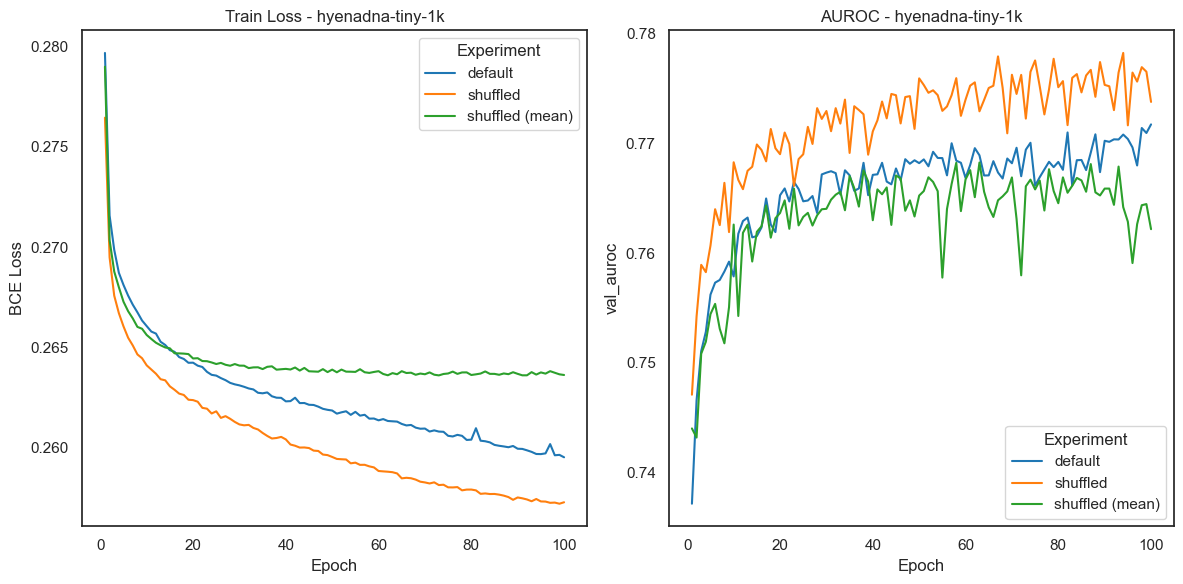

In [95]:
fig = plot_loss_curves(df_losses)

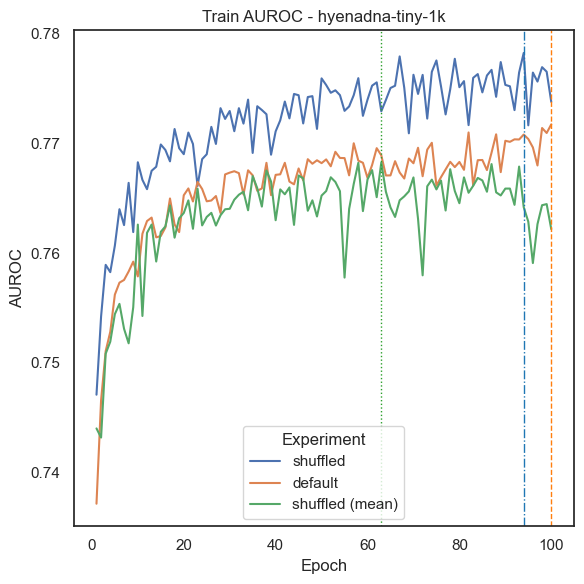

In [89]:
fig = plot_auroc_curves(df_losses, df_tests)
# plt.title(f'Validation AUROC of HyneaDNA-tiny-1k on CpG Methylation Task')
# plt.savefig(f'val_AUROC_{MODEL}.png', dpi=300)

In [75]:
print_test_results(df_tests)

| Task                 | Experiment      | Model            |   Epoch |   test_loss |   test_auroc_avg |
|:---------------------|:----------------|:-----------------|--------:|------------:|-----------------:|
| histone modification | shuffled        | hyenadna-tiny-1k |  94.000 |       0.257 |            0.772 |
| histone modification | default         | hyenadna-tiny-1k | 100.000 |       0.258 |            0.766 |
| histone modification | shuffled (mean) | hyenadna-tiny-1k |  63.000 |       0.259 |            0.761 |
